# Introduction

## Dataset

## Project goals

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'1.15.0'

In [4]:
!python3 -m pip install tensorflow==2.0.0

  Using cached https://files.pythonhosted.org/packages/b9/88/f6b026a424d66d185534cb356fecaa63c96540227c306b2d96b61385f8d1/tensorflow-2.0.0-cp35-cp35m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/76/54/99b9d5d52d5cb732f099baaaf7740403e83fe6b0cedde940fabd2b13d75a/tensorboard-2.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fc/08/8b927337b7019c374719145d1dceba21a8bb909b93b1ad6f8fb7d22c1ca1/tensorflow_estimator-2.0.1-py2.py3-none-any.whl
ERROR: tensorflow-io 0.8.0 has requirement tensorflow<1.16.0,>=1.15.0, but you'll have tensorflow 2.0.0 which is incompatible.
ERROR: tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/bin/tensorboard'
Consider using the `--user` option

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
print(tf.__version__)

1.15.0


In [6]:
from tensorflow import keras

# Working with directory library
from os import path, listdir
from os.path import isdir

# Image visualization
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

In [7]:
# Define function to load image from path, return all image paths and labels
import os

# Load image
def load_image_dataset(train_path):
    all_image_dirs = [os.path.join(train_path, f) for f in listdir(train_path) if not isdir(os.path.join(train_path, f))]
    all_image_labels = []
    for f in all_image_dirs:
        if f.split('.')[0][-3:] == 'cat':
            all_image_labels.append(0)
        else:
            all_image_labels.append(1)
    return all_image_dirs, all_image_labels
    

In [8]:
train_path = 'train/train'

all_image_dirs, all_image_labels = load_image_dataset(train_path)
len(all_image_dirs)
len(all_image_labels) 

25000

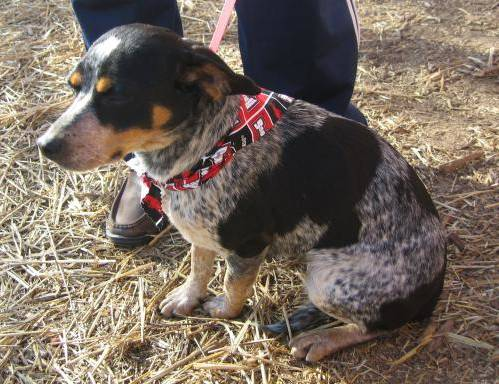

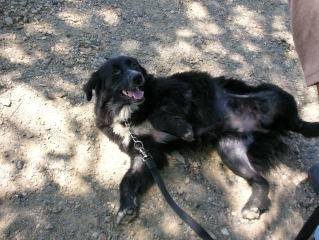

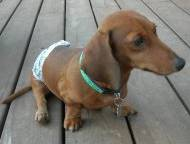

In [9]:
# Libraries to plot image from directory path
import IPython.display as display
import random
    
for i in range(3):
    img = random.choice(all_image_dirs)
    display.display(display.Image(img))
    print()

    

In [11]:
# # Taking img path
# img_path = all_image_dirs[0]

# # Read the img file
# img_raw = tf.io.read_file(img_path)

# # Decode into image tensor
# img_tensor = tf.image.decode_jpeg(img_raw, channels=3) 

# # Resize
# img_tensor = tf.image.resize(img_tensor, [192, 192])

# # Reduce its range to 0, 1
# img_final = img_tensor / 255.

# img_final = 2*img -1

# print(img_final.shape)


In [12]:
# Function to take care of preprocessing image 
def decoding_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [192,192])
    img /= 255.0 # normalize to [0,1] range
    img = 2*img -1 # normalize to [-1,1] range
    
    return img



In [13]:
all_image_dirs[10]

'train/train/cat.9511.jpg'

In [14]:
import matplotlib.pyplot as plt

img_path = all_image_dirs[10]
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [192,192])
img /= 255.0 # normalize to [0,1] range
img = 2*img -1 # normalize to [-1,1] range
    

- Load and preprocess all image in all_image_path

In [15]:
ds = tf.data.Dataset.from_tensor_slices((all_image_dirs, all_image_labels))

In [16]:
# Split data into train and test set
no_train = int(len(all_image_labels)*0.8//1)
train_img, train_labels = all_image_dirs[:no_train], all_image_labels[:no_train]
test_img, test_labels = all_image_dirs[no_train:], all_image_labels[no_train:]

In [17]:
# using tensor slices to form dataset
train_path_label = tf.data.Dataset.from_tensor_slices((train_img, train_labels))

test_path_label = tf.data.Dataset.from_tensor_slices((test_img, test_labels))

In [18]:
# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(img_path, label):
    return decoding_img(img_path), label

In [19]:
# Create dataset with image and its label
train_image_label_ds = train_path_label.map(load_and_preprocess_from_path_label)

# Create dataset with image and its label
test_image_label_ds = test_path_label.map(load_and_preprocess_from_path_label)

test_image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

**To train a model with this dataset, you will want the data:**

    - To be well shuffeled
    - To be batched
    - To repeat forever
    - Batches to be available as soon as possible

In [20]:
# implement batch for train set.

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_image_label_ds.shuffle(buffer_size = len(all_image_labels))
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [21]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(no_train, activation = 'softmax')])

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20000)             25620000  
Total params: 27,877,984
Trainable params: 25,620,000
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
BATCH_SIZE = 32

steps_per_epoch=len(all_image_dirs)/BATCH_SIZE
history = model.fit(train_ds, epochs=2, steps_per_epoch=steps_per_epoch)

Train on 781.25 steps
Epoch 1/2
782/781 [==============================] - 941s 1s/step - loss: 0.2206 - acc: 0.9398
Epoch 2/2
782/781 [==============================] - 680s 869ms/step - loss: 0.1029 - acc: 0.9588


In [26]:
# save model for flask usage.

model.save('dog_cat.h5')

In [27]:
# Save tf.keras model in HDF5 format.
keras_file = "dog_cat.h5"
tf.keras.models.save_model(model, keras_file)

# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 262 variables.
INFO:tensorflow:Converted 262 variables to const ops.


111332520